# Part 3

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 1. Data loading & preprocessing
The CIFAR-10 dataset contains 60,000 images(32x32x3) in 10 different classes, with 6,000 images in each class.

In [267]:
import numpy as np
from PIL import Image
import zipfile
import os


# Prepare the training and testing image sets.
def unzipDataset(data_dir):
    zip_path = data_dir + '.zip'
    extract_path = os.getcwd()

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

train_dir = 'train'
test_dir = 'test'

unzipDataset(train_dir)
unzipDataset(test_dir)

In [292]:
def enhance_color(image, alpha=1.2, beta=20, saturation_scale=1.5):
    # Adjust contrast and brightness
    enhanced_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2HSV)
    # Scale the saturation channel
    hsv_image[:, :, 1] = cv2.multiply(hsv_image[:, :, 1], saturation_scale)
    # Convert back to RGB color space
    color_enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return color_enhanced_image

# Function to enhance image clarity
def enhance_image(image):
    yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    yuv_image[:, :, 0] = cv2.equalizeHist(yuv_image[:, :, 0])
    enhanced_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_image = cv2.filter2D(enhanced_image, -1, kernel)
    return sharpened_image


# Function to preprocess images by enhancing and applying edge detection
def preprocess_image(image):
    color_enhanced_image = enhance_color(image)
    enhanced_image = enhance_image(color_enhanced_image)
    return enhanced_image

In [293]:
# Function to load training data
def loadTrain(root_dir, csv_file):
    ids = []
    images = []
    labels = []
    annotations = np.genfromtxt(csv_file, delimiter=',', names=True)
    for idx in range(len(annotations)):
        img_id = int(annotations['id'][idx])
        img_name = os.path.join(root_dir, f"image_{img_id}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        image = preprocess_image(image)
        label = int(annotations['label'][idx])
        ids.append(img_id)
        images.append(image)
        labels.append(label)
    return np.array(ids), np.array(images), np.array(labels)

# Function to load testing data
def loadTest(root_dir):
    ids = []
    images = []
    for idx in range(len(os.listdir(root_dir))):
        img_name = os.path.join(root_dir, f"image_{idx}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        image = preprocess_image(image)
        ids.append(idx)
        images.append(image)
    return np.array(ids), np.array(images)

In [310]:
# Load training, testing data and the training label provided in train.csv.
train_csv = 'train.csv'
id_train, X_train, y_train = loadTrain(train_dir, train_csv)
id_test, X_test = loadTest(test_dir)

#### Image after preprocessing

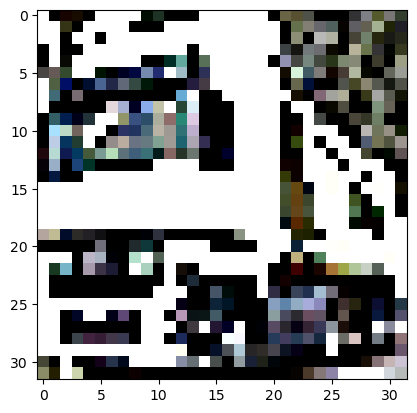

In [312]:
plt.imshow(X_train[1].astype('uint8'))

In [313]:
# Normalize the data to fit in to an CNN model.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [314]:
from sklearn.model_selection import train_test_split
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

## 2. Build & train the model

In [315]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  
    fill_mode='nearest'
)


# Fit the data augmentation on the training data
datagen.fit(X_train)

In [316]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

# Define the CNN model with L2 regularization and more Dropout
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
cnn_model = create_cnn_model()

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

C:\Users\28612\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.2142 - loss: 2.2561 - val_accuracy: 0.4532 - val_loss: 1.7016
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4390 - loss: 1.6873 - val_accuracy: 0.5507 - val_loss: 1.4466
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4893 - loss: 1.5859 - val_accuracy: 0.5868 - val_loss: 1.3962
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5189 - loss: 1.5353 - val_accuracy: 0.5759 - val_loss: 1.3981
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5411 - loss: 1.4907 - val_accuracy: 0.6031 - val_loss: 1.3473
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5479 - loss: 1.4785 - val_accuracy: 0.6166 - val_loss: 1.2925
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5612 - loss: 1.4523 - val_accuracy: 0.6372 - val_loss: 1.2797
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5692 - loss: 1

## Evaluation

In [323]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import seaborn as sns

In [324]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_val, y_val)
print(f'Val Accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6573 - loss: 1.2168
Val Accuracy: 0.6559000015258789


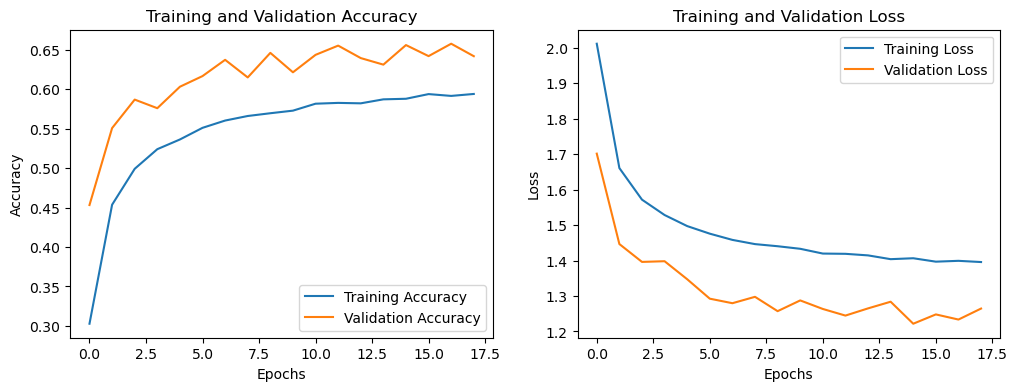

In [325]:
def plot_history(history):
    # Plotting accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_history(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix:
 [[413  33  97  31  70 126  33 144  11   7]
 [ 47 698 118   5  28  57  24  17  24   4]
 [ 35  81 635  13  37  11  48  71  12   4]
 [ 15   2  11 801  12   3 137   6  28  25]
 [ 39  29 132  26 418  65  94 144  12   6]
 [228  66 110  12  46 483  12  59   6   4]
 [ 24  14  37 125  59   3 686  19  35  23]
 [ 43  11  56   5  34  12  13 810   2   7]
 [  9   8  12  33   6   5  34  15 840  39]
 [  7   5  11  62   5   2  32  10 107 775]]
Precision: 0.66
Recall: 0.65
F1-Score: 0.65
Accuracy: 0.66


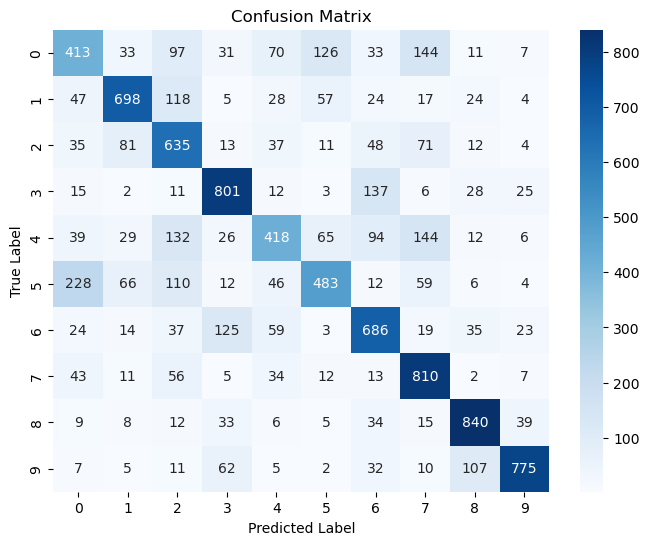

In [328]:
y_pred_classes = np.argmax(cnn_model.predict(X_val), axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Precision, Recall, F1-score, Accuracy
precision = precision_score(y_val, y_pred_classes, average='macro')
recall = recall_score(y_val, y_pred_classes, average='macro')
f1 = f1_score(y_val, y_pred_classes, average='macro')
accuracy = accuracy_score(y_val, y_pred_classes)

print("Confusion Matrix:\n", conf_matrix)
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


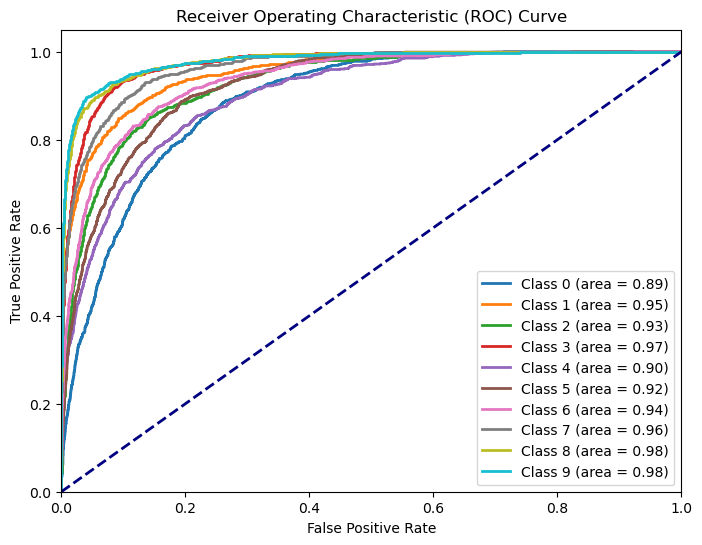

In [329]:
from sklearn.preprocessing import label_binarize

# Binarize the output
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], cnn_model.predict(X_val)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [322]:
# Make predictions.
predictions = cnn_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare your submission file.
submission = np.column_stack((id_test, predicted_labels))
np.savetxt('submission.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# Summary